In [29]:
# Import OS module
import os

# Imports
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Notebook magic
%matplotlib inline

In [30]:
# Check if GPU available
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [31]:
# Configure variables for Transfer learning
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
grid_shape = (1, image_size, image_size, 3)

batch_size = 32

In [32]:
dataset_root = "/kaggle/input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"

train_dir = os.path.join(dataset_root, "train")
test_dir = os.path.join(dataset_root, "valid")


In [33]:
# Define augmentations for train dataset and read the images
train_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0,
    # Filling for W/H shift
    fill_mode="nearest",
    # Width and Height shift
    width_shift_range=0.2,
    height_shift_range=0.2,
    # Random zooms
    zoom_range=0.2,
    # Random Shearing aug
    shear_range=0.2,
)

# Read data from directory
train_data = train_aug.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)


Found 70295 images belonging to 38 classes.


In [34]:
# Get the list of categories in training data
cats = list(train_data.class_indices.keys())


In [35]:
# Augmentations for test data
test_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0
)

# Read data from directory
test_data = test_aug.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 17572 images belonging to 38 classes.


## Model Building

In [36]:
# Load the base model
mbnet_v2 = keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)

# Stop from being trainable
mbnet_v2.trainable = False

In [37]:
# Define the layers
inputs = keras.Input(shape=input_shape)

# Get the layer
x = mbnet_v2(inputs, training = False)

# Stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(cats), activation="softmax")(x)

# Combine the model
model = Model(inputs=inputs, outputs=x)

# Summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 38)                  │          48,678 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [38]:
# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=3)

In [39]:
# Num epochs
epochs = 10

# Train model
history = model.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=150,
    callbacks=[early_stopping_cb]
)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.2876 - loss: 2.7659
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 150s 1000ms/step - accuracy: 0.7451 - loss: 0.9513
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.8102 - loss: 0.6775
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.8357 - loss: 0.5557
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 149s 997ms/step - accuracy: 0.8512 - loss: 0.5074
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.8626 - loss: 0.4656
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.8547 - loss: 0.4554
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.8776 - loss: 0.3982
Epoch 9/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.8679 - loss: 0.4155
Epoch 10/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.8874 - loss: 0.3694 


In [40]:
model.evaluate(test_data)

550/550 ━━━━━━━━━━━━━━━━━━━━ 450s 815ms/step - accuracy: 0.8956 - loss: 0.3362


[0.34398695826530457, 0.8935238122940063]

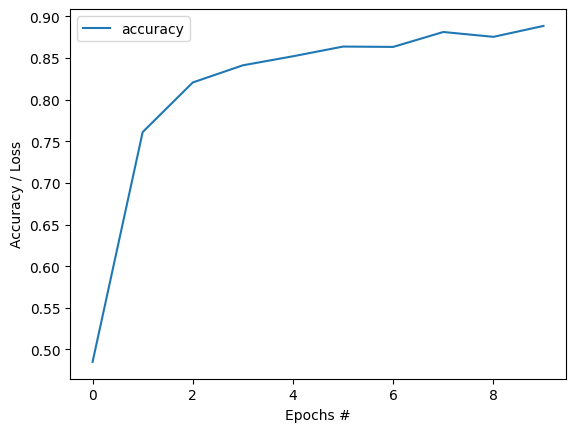

In [46]:
# Plotting
hist = history.history

# Plot accuracy and loss
plt.plot(hist["accuracy"], label="accuracy")

if "val_accuracy" in hist and "val_loss" in hist:
    plt.plot(hist["val_accuracy"], label="val_accuracy")
    plt.plot(hist["val_loss"], label="val_loss")

# Add the labels and legend
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epochs #")
plt.legend()

# Finally show the plot
plt.show()

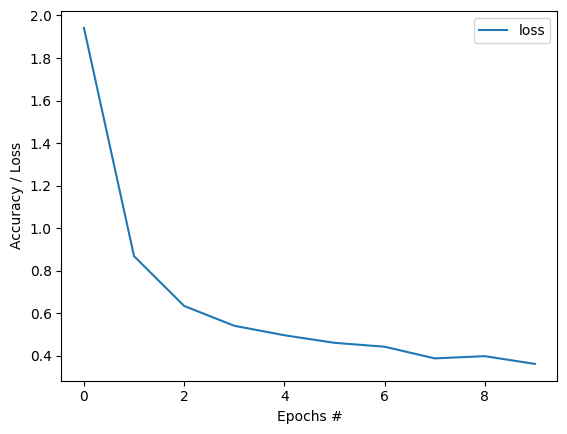

In [48]:
# Plotting
hist = history.history

# Plot accuracy and loss
plt.plot(hist["loss"], label="loss")

if "val_accuracy" in hist and "val_loss" in hist:
    plt.plot(hist["val_accuracy"], label="val_accuracy")
    plt.plot(hist["val_loss"], label="val_loss")

# Add the labels and legend
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epochs #")
plt.legend()

# Finally show the plot
plt.show()

In [42]:
model.save("plant_disease_detection.h5")


In [43]:
import json

from IPython.display import FileLink

# Link the files
FileLink("./plant_disease_detection.h5")

/kaggle/working/plant_disease_detection.h5

In [44]:
# Dump the categories
with open("categories.json", "w") as file:
  json.dump(train_data.class_indices, file)

# Link categories JSON
FileLink("categories.json")


/kaggle/working/categories.json